<a href="https://colab.research.google.com/github/Joh-Ishimwe/fashion_recommendation/blob/master/fashion_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# The Dataset

## Problem Statement

Existing fashion recommendation systems often lack deep personalization, resulting in suboptimal outfit suggestions and user frustration. This project aims to develop a machine learning model that classifies fashion items based on key attributes to enhance personalized recommendations, leading to more relevant and satisfying user experiences.

## Dataset Description

This project utilizes a synthetically generated dataset created using Pandas due to the limited availability of suitable real-world datasets for the specific needs of this model. The dataset comprises 1,000 samples, each representing a fashion item. The features used for classification include:

- **gender:** Gender of the intended wearer (Men, Women, Unisex, Boys, Girls).
- **masterCategory:** Broad product category (Apparel, Accessories, Footwear, etc.).
- **subCategory:** More specific product category (Topwear, Shoes, Bags, etc.).
- **articleType:** Specific product type (T-shirts, Shirts, Casual Shoes, etc.).
- **baseColour:** Primary color of the item (Black, White, Blue, etc.).
- **season:** Seasonality of the item (Summer, Fall, Winter, Spring).
- **year:** Year of release or purchase.
- **usage:** Intended usage or style category (Casual, Sports, Ethnic, Formal, Party, Smart Casual, Travel, Home).

The model aims to predict the 'usage' category based on the other features, enabling personalized fashion recommendations tailored to user preferences and occasion.

In [2]:
# Define categories
genders = ["Men", "Women", "Unisex", "Boys", "Girls"]
master_categories = ["Apparel", "Accessories", "Footwear", "Personal Care", "Free Items", "Sporting Goods", "Home"]
sub_categories = ["Topwear", "Shoes", "Bags", "Bottomwear", "Watches", "Innerwear", "Jewellery", "Eyewear", "Fragrance",
                  "Sandal", "Wallets", "Flip Flops", "Belts", "Socks", "Lips", "Dress", "Loungewear and Nightwear",
                  "Saree", "Nails", "Makeup", "Headwear", "Ties", "Accessories", "Scarves", "Cufflinks", "Apparel Set",
                  "Free Gifts", "Stoles", "Skin Care", "Skin", "Eyes", "Mufflers", "Shoe Accessories", "Sports Equipment",
                  "Gloves", "Hair", "Bath and Body", "Water Bottle", "Perfumes", "Umbrellas", "Beauty Accessories",
                  "Wristbands", "Sports Accessories", "Home Furnishing", "Vouchers"]
article_types = ["Tshirts", "Shirts", "Casual Shoes", "Watches", "Sports Shoes", "Cushion Covers", "Mens Grooming Kit",
                 "Body Wash and Scrub", "Suits", "Ipad"]
base_colours = ["Black", "White", "Blue", "Brown", "Grey", "Red", "Green", "Pink", "Navy", "Purple", "Silver", "Yellow",
                "Beige", "Gold", "Maroon", "Orange", "Olive", "Multi", "Cream", "Steel", "Charcoal", "Peach", "OffWhite",
                "Skin", "Lavender", "Grey Melange", "Khaki", "Magenta", "Teal", "Tan", "Mustard", "Bronze", "Copper",
                "Turquoise", "Rust", "Burgundy", "Metallic", "Coffee Brown", "Mauve", "Rose", "Nude", "Sea Green",
                "Mushroom Brown", "Taupe", "Unknown", "Lime Green", "Fluorescent Green"]
seasons = ["Summer", "Fall", "Winter", "Spring"]
usages = ["Casual", "Sports", "Ethnic", "Formal", "Party", "Smart Casual", "Travel", "Home"]

# Usage rules
usage_rules = {
    "Sports": {"gender": ["Men", "Women", "Unisex"], "masterCategory": ["Apparel", "Footwear", "Sporting Goods"],
               "subCategory": ["Sports Shoes", "Sports Equipment", "Sports Accessories", "Topwear", "Bottomwear"],
               "articleType": ["Sports Shoes", "Tshirts"], "baseColour": ["Black", "Blue", "Red", "White"], "season": ["Summer", "Winter"]},
    "Formal": {"gender": ["Men", "Women"], "masterCategory": ["Apparel", "Accessories"],
               "subCategory": ["Suits", "Shirts", "Dress", "Watches", "Belts"], "articleType": ["Suits", "Shirts", "Watches"],
               "baseColour": ["Black", "Blue", "Grey", "White"], "season": ["Fall", "Winter"]},
    "Party": {"gender": ["Men", "Women", "Unisex"], "masterCategory": ["Apparel", "Accessories"],
              "subCategory": ["Dress", "Jewellery", "Eyewear", "Topwear"], "articleType": ["Dress", "Tshirts"],
              "baseColour": ["Black", "Red", "Gold", "Silver", "Multi"], "season": ["Summer", "Winter"]},
    "Casual": {"gender": ["Men", "Women", "Unisex"], "masterCategory": ["Apparel", "Footwear"],
               "subCategory": ["Tshirts", "Casual Shoes", "Jeans", "Shorts"], "articleType": ["Tshirts", "Casual Shoes"],
               "baseColour": ["Blue", "Black", "Grey", "White"], "season": ["Summer", "Spring"]},
    "Ethnic": {"gender": ["Men", "Women"], "masterCategory": ["Apparel"], "subCategory": ["Saree", "Kurta", "Ethnic Wear"],
               "articleType": ["Saree", "Kurta"], "baseColour": ["Red", "Gold", "Green", "Blue"], "season": ["Fall", "Winter", "Spring"]},
    "Smart Casual": {"gender": ["Men", "Women", "Unisex"], "masterCategory": ["Apparel", "Footwear"],
                     "subCategory": ["Shirts", "Casual Shoes", "Topwear"], "articleType": ["Shirts", "Tshirts"],
                     "baseColour": ["Grey", "Blue", "White"], "season": ["Spring", "Fall"]},
    "Travel": {"gender": ["Unisex"], "masterCategory": ["Apparel", "Accessories"], "subCategory": ["Bottomwear", "Bags"],
               "articleType": ["Tshirts"], "baseColour": ["Black", "Green"], "season": ["Summer", "Spring"]},
    "Home": {"gender": ["Unisex"], "masterCategory": ["Home", "Apparel"], "subCategory": ["Loungewear and Nightwear", "Home Furnishing"],
             "articleType": ["Cushion Covers"], "baseColour": ["Beige", "White"], "season": ["All"]}
}

# Data generation functions
def generate_sample(usage):
    rules = usage_rules.get(usage, {})
    sample = {
        "gender": np.random.choice(rules.get("gender", genders)),
        "masterCategory": np.random.choice(rules.get("masterCategory", master_categories)),
        "subCategory": np.random.choice(rules.get("subCategory", sub_categories)),
        "articleType": np.random.choice(rules.get("articleType", article_types)),
        "baseColour": np.random.choice(rules.get("baseColour", base_colours)),
        "season": np.random.choice(rules.get("season", seasons)),
        "year": np.random.randint(2010, 2025),
        "usage": usage
    }
    return sample

def generate_fashion_data(num_samples=1000):
    np.random.seed(42)
    usage_distribution = {"Casual": 0.3, "Sports": 0.2, "Ethnic": 0.15, "Formal": 0.15, "Party": 0.1,
                          "Smart Casual": 0.05, "Travel": 0.03, "Home": 0.02}
    samples = []
    for usage, prob in usage_distribution.items():
        num = int(num_samples * prob)
        samples.extend([generate_sample(usage) for _ in range(num)])
    df = pd.DataFrame(samples)
    df["id"] = np.arange(1, len(df) + 1)
    df["productDisplayName"] = ["Product " + str(i) for i in df["id"]]
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df[df.apply(lambda row: validate_sample(row), axis=1)]
    return df

def validate_sample(row):
    if row['masterCategory'] == 'Footwear' and row['articleType'] not in ['Casual Shoes', 'Sports Shoes']:
        return False
    return True

# Preprocessing function
def preprocess_data(df):
    X = df.drop(columns=['usage', 'id', 'productDisplayName'])
    y = df['usage']
    X_encoded = pd.get_dummies(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return X_scaled, y_encoded, X_encoded.columns, scaler, le

# Generate and display data
fashion_df = generate_fashion_data()
fashion_df.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,id,productDisplayName
0,Women,Apparel,Kurta,Saree,Gold,Fall,2022,Ethnic,522,Product 522
1,Men,Accessories,Dress,Watches,White,Winter,2015,Formal,738,Product 738
2,Men,Apparel,Shirts,Watches,Grey,Fall,2015,Formal,741,Product 741
3,Men,Apparel,Watches,Shirts,Black,Winter,2020,Formal,661,Product 661
5,Women,Apparel,Dress,Watches,White,Fall,2023,Formal,679,Product 679


In [3]:
# Save the synthetic data as a CSV file
fashion_df.to_csv("fashion_df.csv", index=False)


# Data Overview
The synthetic dataset contains 1,000 fashion items with features like gender, masterCategory, and usage. Below is a quick summary of its structure and distributions.

In [4]:
# Get information about data types and missing values
fashion_df.info()

# Get summary statistics
fashion_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 870 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gender              870 non-null    object
 1   masterCategory      870 non-null    object
 2   subCategory         870 non-null    object
 3   articleType         870 non-null    object
 4   baseColour          870 non-null    object
 5   season              870 non-null    object
 6   year                870 non-null    int64 
 7   usage               870 non-null    object
 8   id                  870 non-null    int64 
 9   productDisplayName  870 non-null    object
dtypes: int64(2), object(8)
memory usage: 74.8+ KB


,year,id
count,870.000000,870.000000
mean,2016.819540,520.893103
std,4.359911,279.108982
min,2010.000000,2.000000
25%,2013.000000,288.250000
50%,2017.000000,538.500000
75%,2021.000000,755.750000
max,2024.000000,1000.000000


In [5]:
# Basic EDA
print("Dataset Shape:", fashion_df.shape)
print("\nMissing Values:\n", fashion_df.isnull().sum())
print("\nUsage Distribution:\n", fashion_df['usage'].value_counts())

Dataset Shape: (870, 10)

Missing Values:
 gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
id                    0
productDisplayName    0
dtype: int64

Usage Distribution:
 usage
Casual          229
Sports          168
Formal          150
Ethnic          150
Party           100
Travel           30
Smart Casual     23
Home             20
Name: count, dtype: int64


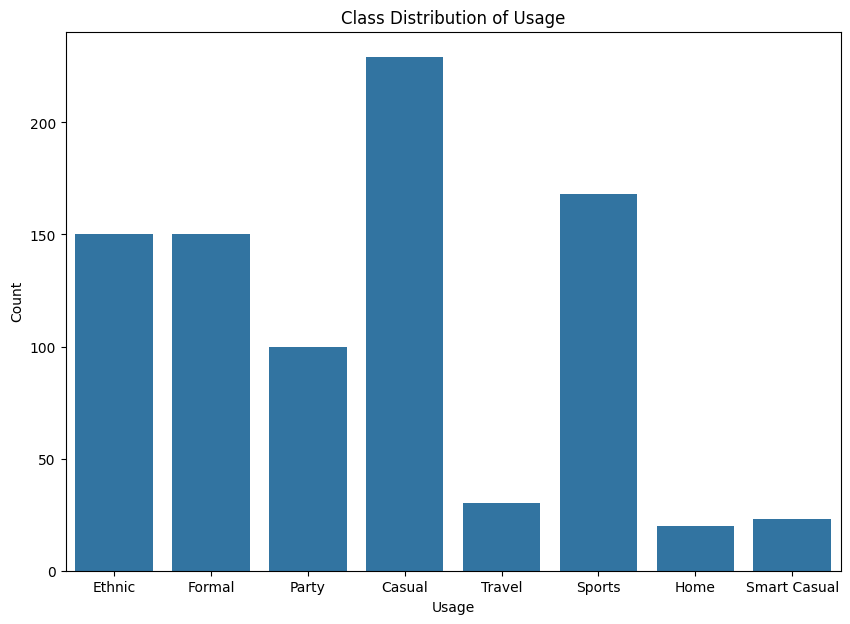

In [6]:
# Visualize the class distribution
plt.figure(figsize=(10, 7))
sns.countplot(x='usage', data=fashion_df)
plt.title('Class Distribution of Usage')
plt.xlabel('Usage')
plt.ylabel('Count')
plt.show()

# Training and evaluation

Split data saved as: X_train.csv, X_test.csv, y_train.csv, y_test.csv
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

      Casual       0.96      1.00      0.98        50
      Ethnic       1.00      1.00      1.00        24
      Formal       0.97      1.00      0.99        36
        Home       1.00      1.00      1.00         7
       Party       1.00      0.95      0.97        20
Smart Casual       1.00      0.40      0.57         5
      Sports       0.97      1.00      0.98        29
      Travel       1.00      1.00      1.00         3

    accuracy                           0.98       174
   macro avg       0.99      0.92      0.94       174
weighted avg       0.98      0.98      0.97       174

Accuracy: 0.9770114942528736
F1 Score (Macro): 0.9369414899963664
Precision (Macro): 0.9876472626472627
Recall (Macro): 0.91875


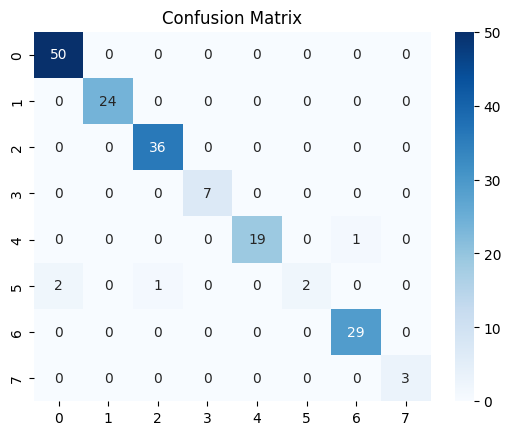

['label_encoder.pkl']

In [7]:
# Training and evaluation function
def train_and_evaluate(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert splits back to DataFrames for saving
    X_train_df = pd.DataFrame(X_train, columns=feature_columns)
    X_test_df = pd.DataFrame(X_test, columns=feature_columns)
    y_train_df = pd.DataFrame(y_train, columns=['usage_encoded'])
    y_test_df = pd.DataFrame(y_test, columns=['usage_encoded'])

    # Save the splits to CSV files
    X_train_df.to_csv('X_train.csv', index=False)
    X_test_df.to_csv('X_test.csv', index=False)
    y_train_df.to_csv('y_train.csv', index=False)
    y_test_df.to_csv('y_test.csv', index=False)
    print("Split data saved as: X_train.csv, X_test.csv, y_train.csv, y_test.csv")

    # Train the model
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    param_grid = {'max_depth': [3, 5], 'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    # Evaluation
    print("Best Parameters:", grid.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score (Macro):", f1_score(y_test, y_pred, average='macro'))
    print("Precision (Macro):", precision_score(y_test, y_pred, average='macro'))
    print("Recall (Macro):", recall_score(y_test, y_pred, average='macro'))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    return grid.best_estimator_

# Preprocess data
X_scaled, y_encoded, feature_columns, scaler, le = preprocess_data(fashion_df)

# Train model and save splits
best_model = train_and_evaluate(X_scaled, y_encoded)

# Save artifacts
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')
joblib.dump(le, 'label_encoder.pkl')

# Predicting

In [8]:
# Prediction function
def make_predictions(model_path, X, le):
    try:
        model = joblib.load(model_path)
        predictions = model.predict(X)
        predicted_categories = le.inverse_transform(predictions)
        return predicted_categories
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found.")
        return None
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

# Load saved artifacts
model_path = "best_model.pkl"
scaler_path = "scaler.pkl"
feature_columns_path = "feature_columns.pkl"
le_path = "label_encoder.pkl"

# Define new input data
X_new = pd.DataFrame({
    'gender': ['Women'],
    'masterCategory': ['Apparel'],
    'subCategory': ['Topwear'],
    'articleType': ['Tshirts'],
    'baseColour': ['Blue'],
    'season': ['Summer'],
    'year': [2023]
})

# Preprocess new data
feature_columns = joblib.load(feature_columns_path)
scaler = joblib.load(scaler_path)
le = joblib.load(le_path)
X_new_encoded = pd.get_dummies(X_new).reindex(columns=feature_columns, fill_value=0)
X_new_scaled = scaler.transform(X_new_encoded)

# Make predictions
predicted_categories = make_predictions(model_path, X_new_scaled, le)
if predicted_categories is not None:
    print("Predicted Usage:", predicted_categories[0])
else:
    print("Prediction failed.")

Predicted Usage: Sports


Interpretation 1: 'Casual' and 'Sports' are popular across genders, while 'Ethnic' is more common for Women.
Interpretation 2: 'Summer' dominates 'Casual' and 'Travel', while 'Winter' aligns with 'Formal' and 'Party'.
Interpretation 3: Neutral colors like 'Black', 'White', and 'Blue' dominate, reflecting versatile usage.


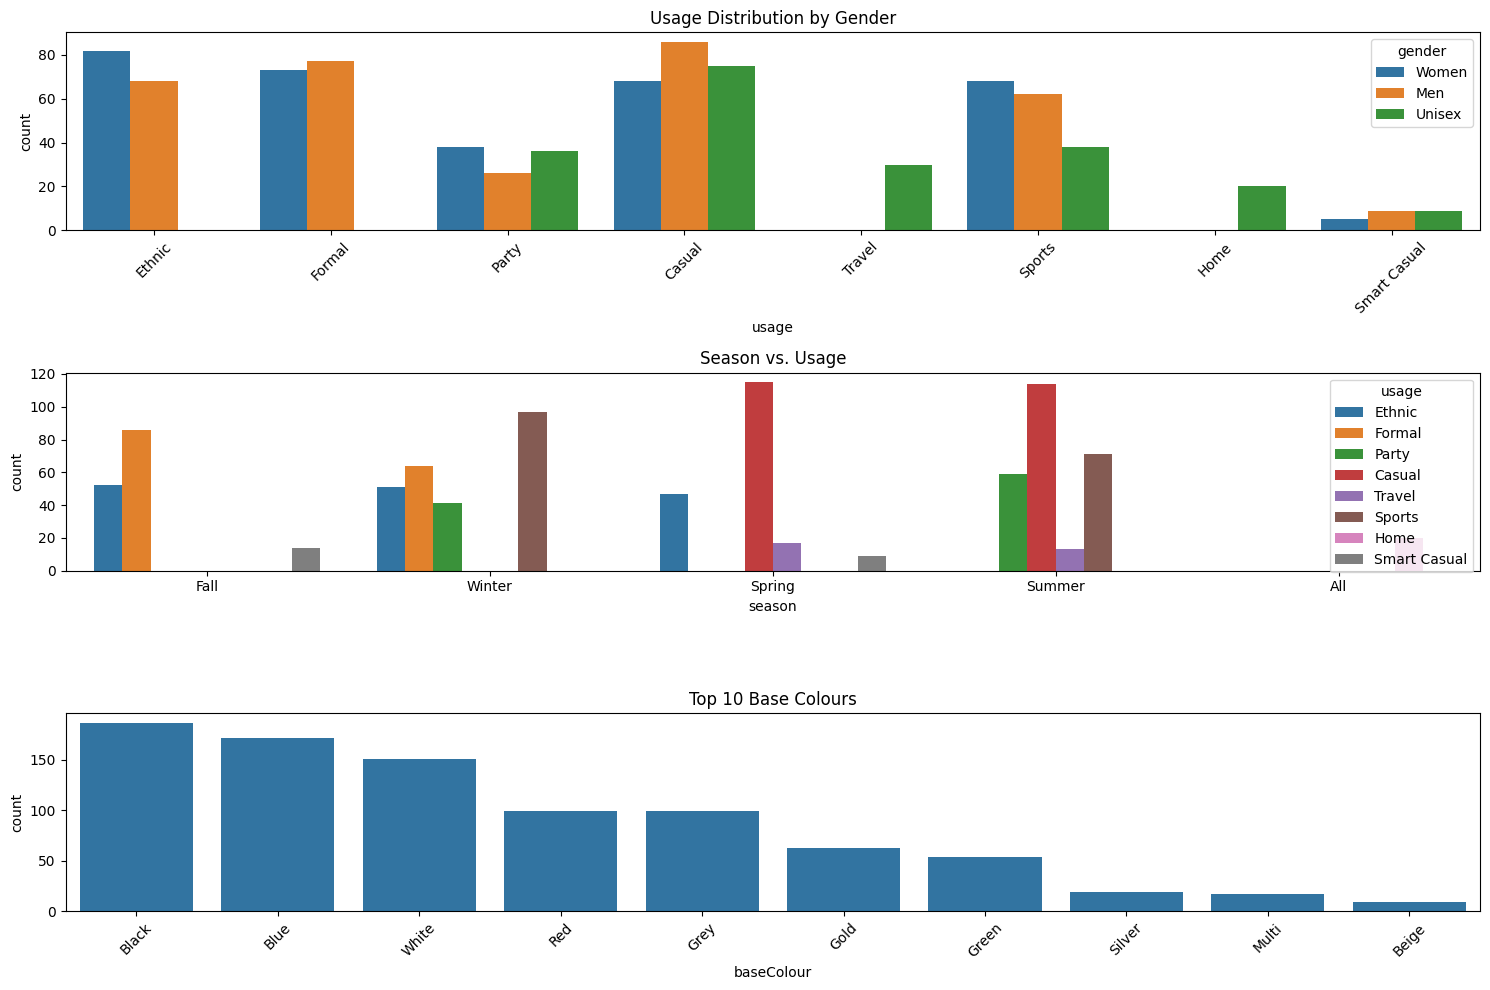

In [9]:
# Visualizations
plt.figure(figsize=(15, 10))

# 1. Usage by Gender
plt.subplot(3, 1, 1)
sns.countplot(data=fashion_df, x='usage', hue='gender')
plt.title("Usage Distribution by Gender")
plt.xticks(rotation=45)
print("Interpretation 1: 'Casual' and 'Sports' are popular across genders, while 'Ethnic' is more common for Women.")

# 2. Season vs. Usage
plt.subplot(3, 1, 2)
sns.countplot(data=fashion_df, x='season', hue='usage')
plt.title("Season vs. Usage")
print("Interpretation 2: 'Summer' dominates 'Casual' and 'Travel', while 'Winter' aligns with 'Formal' and 'Party'.")

# 3. BaseColour Distribution
plt.subplot(3, 1, 3)
sns.countplot(data=fashion_df, x='baseColour', order=fashion_df['baseColour'].value_counts().index[:10])
plt.title("Top 10 Base Colours")
plt.xticks(rotation=45)
print("Interpretation 3: Neutral colors like 'Black', 'White', and 'Blue' dominate, reflecting versatile usage.")

plt.tight_layout()
plt.show()